### 1. The main objective of this work:

*The main objective of this work is to find a machine learning model that can best help the doctor to diagnosis Pneumonia. I will apply TensorFlow, Keras to pre procss the input X-ray images and build several machine learning models to recognize and classify the X-Ray images to be with presence or no presence of Pneumonia in a person. So it is going to be a binary classification.*

*I will compare the performance of the modeles whih I created from this work and then recommend the one which best suite the objective of this work. I will also highlight the possible flaw in the recommended model and suggest the future possible action plan to revisite the model  with additional data or different modeling technique*

### 2. Dataset description

I got the dataset from this LINK https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.


The dataset contains 5856 X-rays images in jpeg format. The dataset is organized into 3 folders (train, test, val) and contains 2 subfolders for each image category (Pneumonia/Normal) which will greatly simplify my work in data processing.


The chest X-ray images (anterior-posterior) contained in this dataset were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.


For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


Because the X-ray images cannot be directly processed by a neural network, I will use the built-in methods of Keras to pre process data. 

### 3. Getting the data

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'
test_path = 'chest_xray/test'

The photos are of high resolution, on average above 1000x1000. I think the size of these images are too big and processing each such big size of image might take long time to complete. So I choose to resize them to be smaller size 100x100.

In [3]:
# Define a function for getting the image data in size 100*100. 

img_size = 100

def read_data(data_path):
    labels = ['PNEUMONIA', 'NORMAL']
    images = []
    y = []
    for label in labels:
        curr_path = data_path + '/'+label
        for img in os.listdir(curr_path):
            image_path = os.path.join(curr_path, img)
            image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
            if image is not None:
                images.append([image, label])     
    
    images = np.asarray(images, dtype='object')
    return images

In [4]:
# Read train, test, and val dataset

train_dataset = read_data(train_path)
test_dataset = read_data(test_path)
val_dataset = read_data(val_path)

In [5]:
# Shuffle the order of the data

for i in range(10):
    np.random.shuffle(train_dataset)
    np.random.shuffle(test_dataset)
    np.random.shuffle(val_dataset)

In [6]:
print("train_dataset: ", train_dataset.shape)
print("test_dataset: ", test_dataset.shape)
print("val_dataset: ", val_dataset.shape)

train_dataset:  (5216, 2)
test_dataset:  (624, 2)
val_dataset:  (16, 2)


### 4. EDA (Exploratory Data Analysis)

Next I am going to explore the data. For ease to visualize my data analysis, I will convert the dataset to dataframe before I proceed to analyze the data. 

In [7]:
# Import the libraries for plotting charts

import matplotlib.pyplot as plt
import seaborn as sns

#### 4.1 Convert dataset to dataframe ####

In [8]:
train_df = pd.DataFrame(train_dataset, columns=['image', 'label'])
test_df = pd.DataFrame(test_dataset, columns = ['image', 'label'])
val_df = pd.DataFrame(val_dataset, columns = ['image', 'label'])
all_df = pd.concat([train_df, test_df, val_df])

In [9]:
print("\n train.df\n",train_df)
print("\n test.df\n",test_df)
print("\n val.df\n",val_df)
print("\n all_df\n", all_df)


 train.df
                                                   image      label
0     [[[0, 0, 0], [0, 0, 0], [10, 10, 10], [17, 17,...  PNEUMONIA
1     [[[60, 60, 60], [63, 63, 63], [64, 64, 64], [8...  PNEUMONIA
2     [[[39, 39, 39], [51, 51, 51], [56, 56, 56], [5...  PNEUMONIA
3     [[[98, 98, 98], [102, 102, 102], [92, 92, 92],...  PNEUMONIA
4     [[[6, 6, 6], [23, 23, 23], [42, 42, 42], [73, ...  PNEUMONIA
...                                                 ...        ...
5211  [[[39, 39, 39], [53, 53, 53], [39, 39, 39], [4...  PNEUMONIA
5212  [[[43, 43, 43], [46, 46, 46], [66, 66, 66], [1...  PNEUMONIA
5213  [[[73, 73, 73], [75, 75, 75], [68, 68, 68], [6...     NORMAL
5214  [[[65, 65, 65], [46, 46, 46], [98, 98, 98], [6...  PNEUMONIA
5215  [[[57, 57, 57], [65, 65, 65], [74, 74, 74], [7...  PNEUMONIA

[5216 rows x 2 columns]

 test.df
                                                  image      label
0    [[[104, 104, 104], [97, 97, 97], [81, 81, 81],...  PNEUMONIA
1    [[[25, 25, 

#### 4.2 Count the images and plot the image count ####

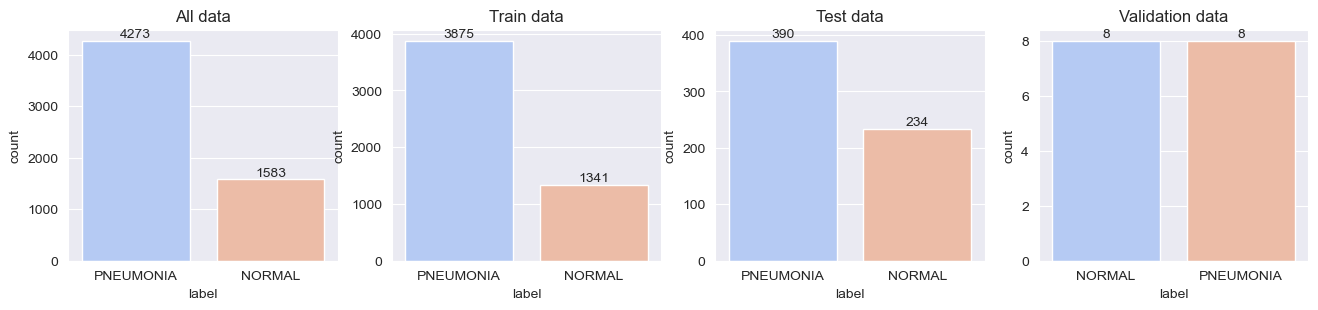

In [10]:
plt.figure(figsize=(16, 3))
sns.set_style("darkgrid")

plt.subplot(1,4,1)
ax0=sns.countplot(x=all_df['label'], data=all_df, palette = 'coolwarm')
plt.title('All data')
ax0.bar_label(ax0.containers[0])


plt.subplot(1,4,2)
ax1=sns.countplot(x=train_df['label'], data=train_df, palette = 'coolwarm')
plt.title('Train data')
ax1.bar_label(ax1.containers[0])

plt.subplot(1,4,3)
ax2=sns.countplot(x=test_df['label'], data=test_df, palette = "coolwarm")
plt.title('Test data')
ax2.bar_label(ax2.containers[0])

plt.subplot(1,4,4)
ax3=sns.countplot(x=val_df['label'], data=val_df, palette = "coolwarm")
plt.title('Validation data')
ax3.bar_label(ax3.containers[0])

plt.show()

#### 4.3 Show examples of images picked up from training dataset ####

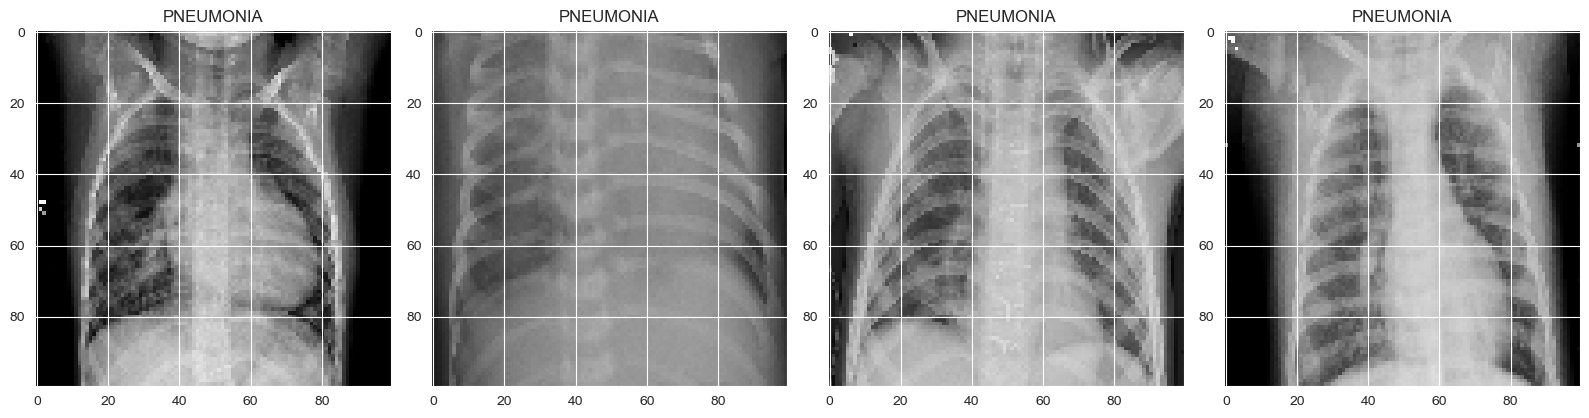

In [11]:
def show_image(data):
    fig = plt.figure(figsize = (16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(data.iloc[i]['image'])
        plt.title("{}".format(train_df.iloc[i]['label']))
        
    plt.tight_layout()
    
show_image(train_df)

#### 4.4 Conclusion ####
- There is significant imbalance of the image classes (Pneumonia vs. Normal). The bar chart shows, in the training dataset, 4273 images are with PNEUMONIA, but only 1583 images are NORMAL. 

- Considering that there is not so much data for training, in future analysis, increasing the size of the dataset for training the model, perhaps is a way to be considered for improving the performance of the model.

### 5. Build the model ###

In [12]:
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Import Keras objects for Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models  import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from keras.optimizers import SGD, Adam, RMSprop
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#### 5.1 Pre process the data ####

In [13]:
# Function to conver categorical value to numberic value in label column

def encode_label(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [14]:
# Function to divide a dataset into two sets: X and y.

def spltdata(data):
    X = []
    y = []
    for i, (feat, label) in enumerate(data):
        X.append(feat)
        y.append(encode_label(label))
    return np.array(X), np.array(y)

In [15]:
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)
X_train, y_train = spltdata(train_dataset)
X_test, y_test = spltdata(test_dataset)
X_val, y_val = spltdata(val_dataset)

In [16]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (5216, 100, 100, 3)
y_train:  (5216,)
X_test:  (624, 100, 100, 3)
y_test:  (624,)
X_val:  (16, 100, 100, 3)
y_val:  (16,)


In [17]:
y_train[:10]

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [18]:
# Convert the images from RGB to Grayscale and reshape/flatten the images from 200*200 to 40,000 columns
X_train1 = X_train.reshape(-1, 100*100*3)/255
X_test1 = X_test.reshape(-1, 100*100*3)/255
X_val1 = X_val.reshape(-1, 100*100*3)/255

In [19]:
print("X_train1: ", X_train1.shape)
print("X_test1: ", X_test1.shape)
print("X_val1: ", X_val1.shape)

X_train1:  (5216, 30000)
X_test1:  (624, 30000)
X_val1:  (16, 30000)


In [20]:
print("X_train1: ", X_train1[5215])
print("X_test1: ", X_test1[623])

X_train1:  [0.01568627 0.01568627 0.01568627 ... 0.         0.         0.        ]
X_test1:  [0.2        0.2        0.2        ... 0.01568627 0.01568627 0.01568627]


#### 5.2 Get a baseline performance using Random Forest ####

1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.


In [21]:
# Train the RF model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train1, y_train)

RandomForestClassifier(n_estimators=200)

In [22]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test1)
y_pred_prob_rf = rf_model.predict_proba(X_test1)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.761
roc-auc is 0.931


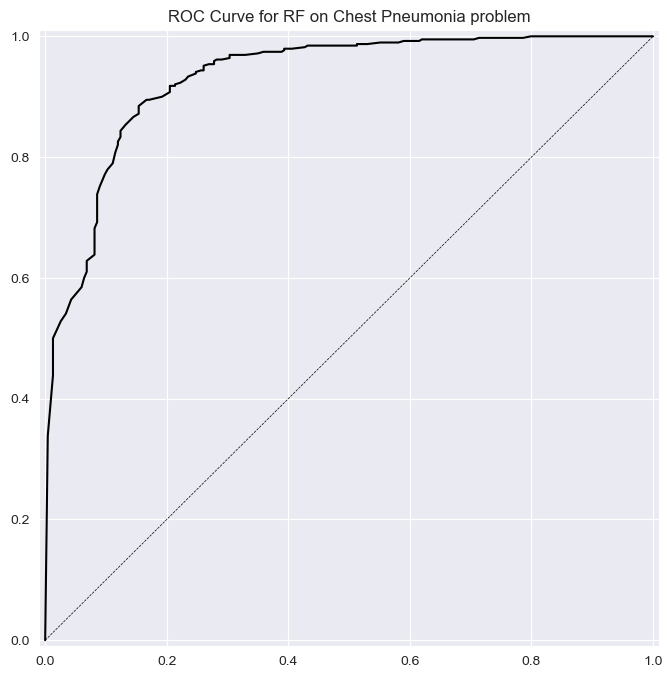

In [23]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Chest Pneumonia problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

**Conclusion:**
**With Random Forrest, accuracy is 0.766; roc-auc is 0.934. We use this as performance baseline.**

#### 5.3 Build a Sequential model ####

In [24]:
# Define the model_1 

model_1 = Sequential()
model_1.add(Dense(32, activation="sigmoid", input_shape = (100, 100, 3)))
model_1.add(Flatten())
model_1.add(Dense(64, activation="relu"))
model_1.add(Dense(128, activation="relu"))
model_1.add(Dense(1, activation="sigmoid"))

2023-02-16 21:21:27.087007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# View the model and count the parameters
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 100, 32)      128       
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense_1 (Dense)             (None, 64)                20480064  
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,488,641
Trainable params: 20,488,641
Non-trainable params: 0
_________________________________________________________________


In [26]:
# define number of epochs
n_epochs=25

# define learning rate
n_lr=0.0005
n_decay=1e-4 # SGD(learning_rate=n_lrm decay=n_decay)

# define loss, ex. binary_crossentropy, categorical_crossentrophy, mean_squared_error
n_loss="binary_crossentropy" 

# define metrics
n_metrics=["accuracy"]

# define optimizer
# opt=SGD(learning_rate=n_lr)
# opt="rmsprop"

# define callbacks
# early_stopping=EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True, verbose = 1, mode="min")
# early_stopping=EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1, mode="min")
# early_stopping=EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose = 1, mode="max")
# lr_reduction=ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_delta=0.01, min_lr=1e-10, patience=1, verbose=1, mode='auto')
# checkpoint=ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode="max", save_best_only=True, save_weights_only=True)
# checkpoint=ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode="max", save_best_only=True, verbose=1)
# CALLBACKS = [early_stopping, checkpoint]
# CALLBACKS = [early_stopping, checkpoint]

In [27]:
# model_1.compile(SGD(learning_rate = .003, decay=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
def train_model(mod, train_data1, train_data2, test_data1, test_data2, f, e, s, m, r):
    early_stopping=EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1, mode="min")
    checkpoint=ModelCheckpoint(filepath=f, monitor='val_accuracy', mode="max", save_best_only=True, verbose=1)
    mod.compile(optimizer=Adam(learning_rate=r), loss=s, metrics=m)
    hist=mod.fit(train_data1, train_data2, validation_data=(test_data1, test_data2), 
                 epochs=e, callbacks=[early_stopping, checkpoint], shuffle=True)
    saved_model = load_model(f)
    predict_X=(saved_model.predict(test_data1)>0.5).astype('int32')
    y_pred_prob = saved_model.predict(test_data1)
    return saved_model, hist, predict_X, y_pred_prob

In [28]:
filepath='best_model_1.h5'
mod_1, run_hist_1, predict_X_1, y_pred_prob_1 = train_model(model_1, X_train, y_train, X_test, y_test, filepath, n_epochs, n_loss, n_metrics, n_lr)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 1.1429 - accuracy: 0.7820
Epoch 1: val_accuracy improved from -inf to 0.78045, saving model to best_model_1.h5
163/163 [==============================] - 15s 93ms/step - loss: 1.1429 - accuracy: 0.7820 - val_loss: 0.4176 - val_accuracy: 0.7804
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.8552 - accuracy: 0.8271
Epoch 2: val_accuracy improved from 0.78045 to 0.80929, saving model to best_model_1.h5
163/163 [==============================] - 15s 93ms/step - loss: 0.8552 - accuracy: 0.8271 - val_loss: 0.4776 - val_accuracy: 0.8093
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9015
Epoch 3: val_accuracy did not improve from 0.80929
163/163 [==============================] - 15s 89ms/step - loss: 0.2335 - accuracy: 0.9015 - val_loss: 0.4369 - val_accuracy: 0.7981
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 

In [29]:
predict_X_1[:10]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [30]:
y_pred_prob_1[:10]

array([[0.10734499],
       [0.26526707],
       [0.9964831 ],
       [0.9801071 ],
       [0.6876268 ],
       [0.9968112 ],
       [0.9420441 ],
       [0.93428165],
       [0.81400204],
       [0.02349138]], dtype=float32)

accuracy is 0.809
roc-auc is 0.885


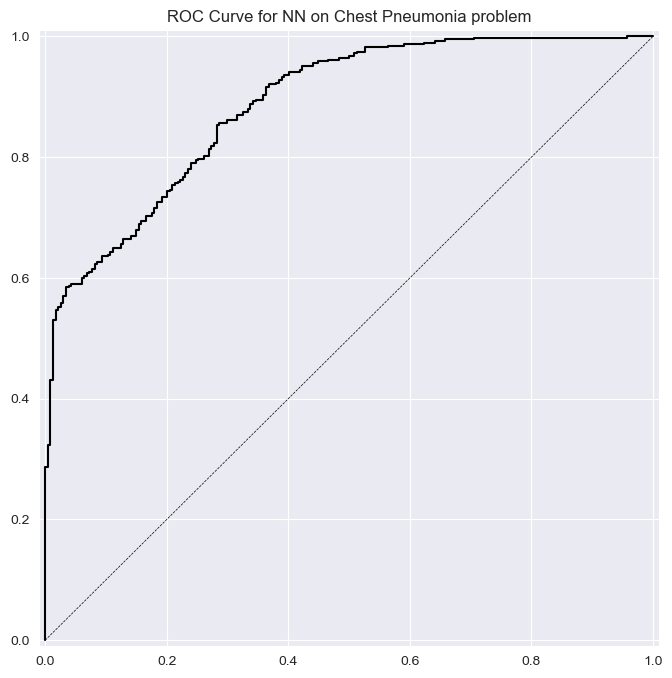

In [31]:
# Print model performance and plot the roc curve
def print_roc(test_data2, pred_X, y_prob, name):
    print('accuracy is {:.3f}'.format(accuracy_score(test_data2,pred_X)))
    print('roc-auc is {:.3f}'.format(roc_auc_score(test_data2,y_prob)))
    plot_roc(test_data2, y_prob, name)

print_roc(y_test, predict_X_1, y_pred_prob_1, "NN")

In [32]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

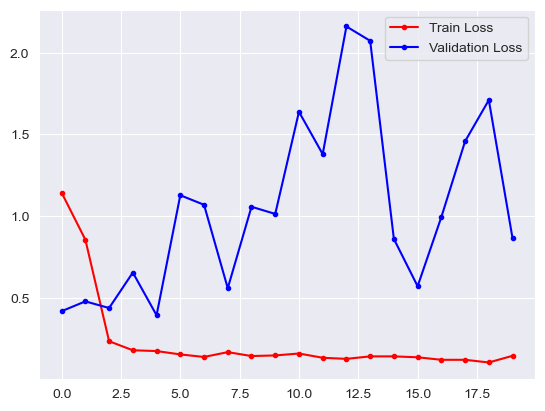

In [33]:
# Plot the training loss and the validation loss over the different epochs.
def plot_train_model(run_h):
    fig, ax = plt.subplots()
    ax.plot(run_h.history["loss"],'r', marker='.', label="Train Loss")
    ax.plot(run_h.history["val_loss"],'b', marker='.', label="Validation Loss")
    ax.legend()

plot_train_model(run_hist_1)

#### 5.4 Build a CNN model using Sequential capabilities ####

In [34]:
# Build a CNN using Keras' Sequential capabilities
model_2 = Sequential()

# convolutional neural networks - CNNs
model_2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'sigmoid' , input_shape = (100,100,3)))
model_2.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model_2.add(Flatten())
model_2.add(Dropout(0.2))
model_2.add(Dense(units = 128 , activation = 'relu'))
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dense(32, activation = "relu"))
model_2.add(Dense(units = 1 , activation = 'sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)      

In [35]:
filepath='best_model_2.h5'
mod_2, run_hist_2, predict_X_2, y_pred_prob_2 = train_model(model_2, X_train, y_train, X_test, y_test, filepath, n_epochs, n_loss, n_metrics, n_lr)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8459
Epoch 1: val_accuracy improved from -inf to 0.73558, saving model to best_model_2.h5
163/163 [==============================] - 28s 169ms/step - loss: 0.3478 - accuracy: 0.8459 - val_loss: 0.8396 - val_accuracy: 0.7356
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9427
Epoch 2: val_accuracy improved from 0.73558 to 0.79327, saving model to best_model_2.h5
163/163 [==============================] - 28s 173ms/step - loss: 0.1511 - accuracy: 0.9427 - val_loss: 0.5213 - val_accuracy: 0.7933
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9576
Epoch 3: val_accuracy did not improve from 0.79327
163/163 [==============================] - 28s 171ms/step - loss: 0.1125 - accuracy: 0.9576 - val_loss: 0.6993 - val_accuracy: 0.7724
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.1099 - accurac

accuracy is 0.793
roc-auc is 0.928


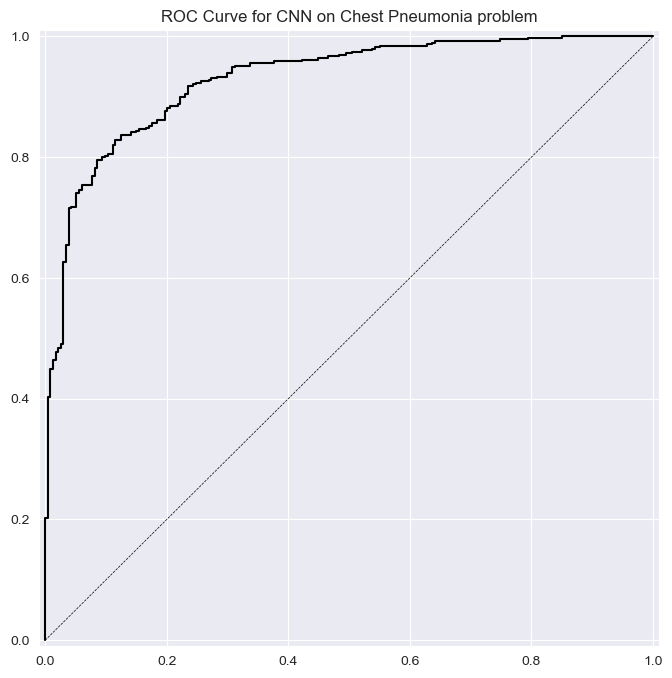

In [36]:
# Print model performance and plot the roc curve
print_roc(y_test, predict_X_2, y_pred_prob_2, "CNN")

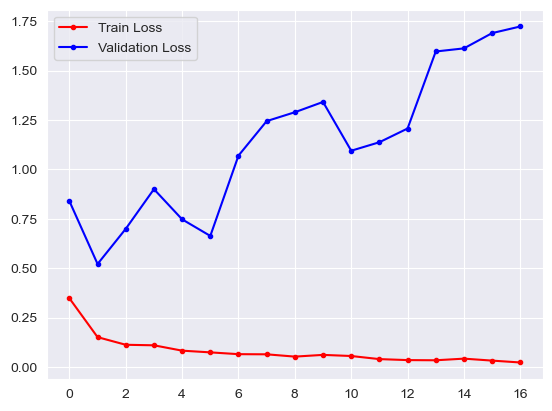

In [37]:
# Plot the training loss and the validation loss over the different epochs.
plot_train_model(run_hist_2)

#### 5.5 Build CNN model by leveraging Transfer Learning 

In [38]:
feature_layers = [
    Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'sigmoid' , input_shape = (100,100,3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Flatten()
]

In [39]:
classification_layers = [
    Dense(units = 128 , activation = 'relu'),
    Dense(units = 64 , activation = 'relu'),
    Dense(units = 32 , activation = 'relu'),
    Dense(units = 1 , activation = 'sigmoid')
]

In [40]:
model_3= Sequential(feature_layers + classification_layers)

In [41]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 128)      

In [42]:
# Freeze the feature layers
for l in feature_layers:
    l.trainable = False

In [43]:
#Train the model
filepath='best_model_3.h5'
mod_3, run_hist_3, predict_X_3, y_pred_prob_3 = train_model(model_3, X_train, y_train, X_test, y_test, filepath, n_epochs, n_loss, n_metrics, n_lr)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8098
Epoch 1: val_accuracy improved from -inf to 0.68590, saving model to best_model_3.h5
163/163 [==============================] - 15s 86ms/step - loss: 0.4120 - accuracy: 0.8098 - val_loss: 0.5284 - val_accuracy: 0.6859
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.8999
Epoch 2: val_accuracy improved from 0.68590 to 0.71955, saving model to best_model_3.h5
163/163 [==============================] - 14s 84ms/step - loss: 0.2431 - accuracy: 0.8999 - val_loss: 0.4968 - val_accuracy: 0.7196
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9339
Epoch 3: val_accuracy did not improve from 0.71955
163/163 [==============================] - 13s 82ms/step - loss: 0.1761 - accuracy: 0.9339 - val_loss: 0.5458 - val_accuracy: 0.7019
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 

accuracy is 0.832
roc-auc is 0.943


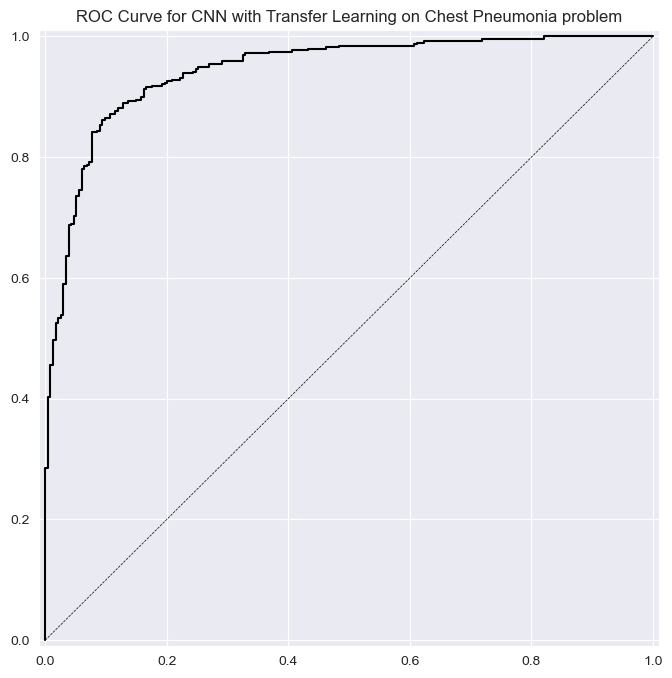

In [44]:
print_roc(y_test, predict_X_3, y_pred_prob_3, "CNN with Transfer Learning")

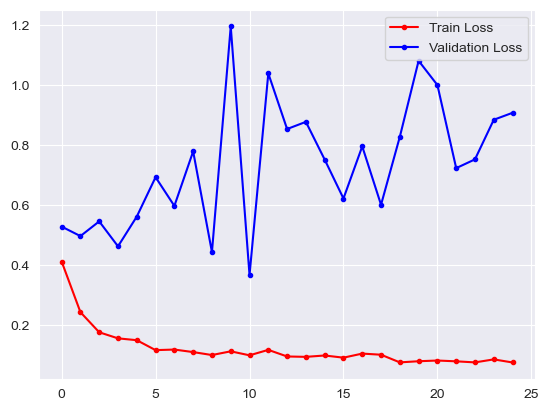

In [45]:
# Plot the training loss and the validation loss over the different epochs.
plot_train_model(run_hist_3)

#### 5.6 CNN Build a model using the Keras application VGG16

In [46]:
# model_4_base = VGG16(weights=None, include_top=False, input_shape=(100, 100, 3))
# model_4_base = VGG16(include_top = False, weights = "imagenet", input_shape = (100, 100, 3), pooling = "max", classes = 2)
model_4_base = VGG16(include_top = False, weights = "imagenet", input_shape = (100, 100, 3))

for l in model_4_base.layers:
    l.trainable = False

model_4_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [47]:
# Build a CNN using VGG16
model_4 = Sequential()
model_4.add(model_4_base)
model_4.add(Flatten())

model_4.add(Dense(units = 128 , activation = 'relu'))
model_4.add(Dense(64, activation = "relu"))
model_4.add(Dense(32, activation = "relu"))
model_4.add(Dense(units = 1 , activation = 'sigmoid'))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               589952    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 15,315,009
Trainable params: 600,321
Non

In [48]:
#Train the model
filepath='best_model_4.h5'
mod_4, run_hist_4, predict_X_4, y_pred_prob_4 = train_model(model_4, X_train, y_train, X_test, y_test, filepath, n_epochs, n_loss, n_metrics, n_lr)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9459
Epoch 1: val_accuracy improved from -inf to 0.81571, saving model to best_model_4.h5
163/163 [==============================] - 76s 464ms/step - loss: 0.1745 - accuracy: 0.9459 - val_loss: 0.6943 - val_accuracy: 0.8157
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9806
Epoch 2: val_accuracy did not improve from 0.81571
163/163 [==============================] - 81s 495ms/step - loss: 0.0584 - accuracy: 0.9806 - val_loss: 0.9614 - val_accuracy: 0.7981
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9881
Epoch 3: val_accuracy improved from 0.81571 to 0.85096, saving model to best_model_4.h5
163/163 [==============================] - 82s 506ms/step - loss: 0.0323 - accuracy: 0.9881 - val_loss: 0.7139 - val_accuracy: 0.8510
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.0288 - accurac

accuracy is 0.873
roc-auc is 0.940


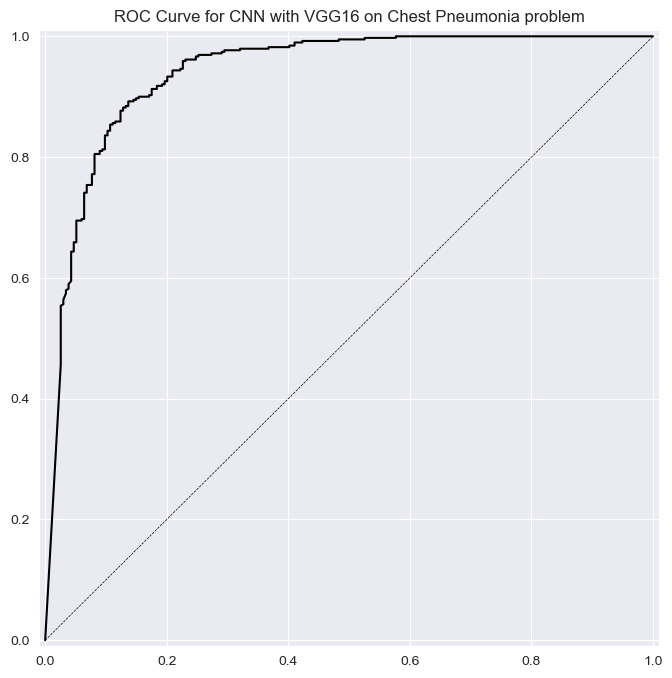

In [49]:
print_roc(y_test, predict_X_4, y_pred_prob_4, "CNN with VGG16")

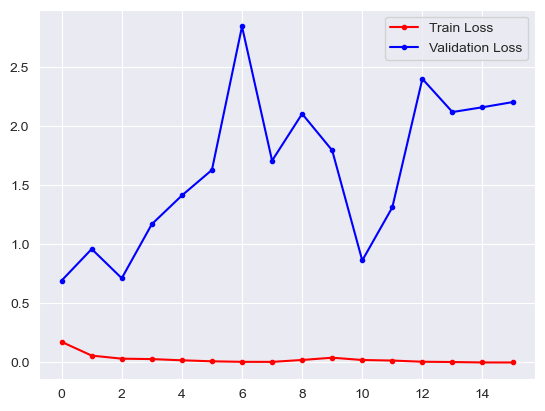

In [50]:
# Plot the training loss and the validation loss over the different epochs.
plot_train_model(run_hist_4)

#### 5.6 Build a CNN model using the Keras application ResNet50

In [51]:
model_5_base = ResNet50(include_top = False, weights = "imagenet", input_shape = (100, 100, 3))

for l in model_5_base.layers:
    l.trainable = False

model_5_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 25, 25, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 25, 25, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 25, 25, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 25, 25, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 13, 13, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 13, 13, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 13, 13, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 13, 13, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 7, 7, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 7, 7, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 7, 7, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 7, 7, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 7, 7, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 7, 7, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [52]:
# Build a CNN using ResNet50
model_5 = Sequential()
model_5.add(model_5_base)
model_5.add(Flatten())

model_5.add(Dense(units = 128 , activation = 'relu'))
model_5.add(Dense(64, activation = "relu"))
model_5.add(Dense(32, activation = "relu"))
model_5.add(Dense(units = 1 , activation = 'sigmoid'))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               4194432   
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 27,792,513
Trainable params: 4,204,801
N

In [53]:
#Train the model
filepath='best_model_5.h5'
mod_5, run_hist_5, predict_X_5, y_pred_prob_5 = train_model(model_5, X_train, y_train, X_test, y_test, filepath, n_epochs, n_loss, n_metrics, n_lr)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9329
Epoch 1: val_accuracy improved from -inf to 0.83173, saving model to best_model_5.h5
163/163 [==============================] - 84s 503ms/step - loss: 0.2161 - accuracy: 0.9329 - val_loss: 0.5798 - val_accuracy: 0.8317
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9847
Epoch 2: val_accuracy improved from 0.83173 to 0.83814, saving model to best_model_5.h5
163/163 [==============================] - 84s 518ms/step - loss: 0.0452 - accuracy: 0.9847 - val_loss: 0.5865 - val_accuracy: 0.8381
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9887
Epoch 3: val_accuracy did not improve from 0.83814
163/163 [==============================] - 88s 540ms/step - loss: 0.0276 - accuracy: 0.9887 - val_loss: 1.7230 - val_accuracy: 0.7292
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.0177 - accurac

accuracy is 0.838
roc-auc is 0.945


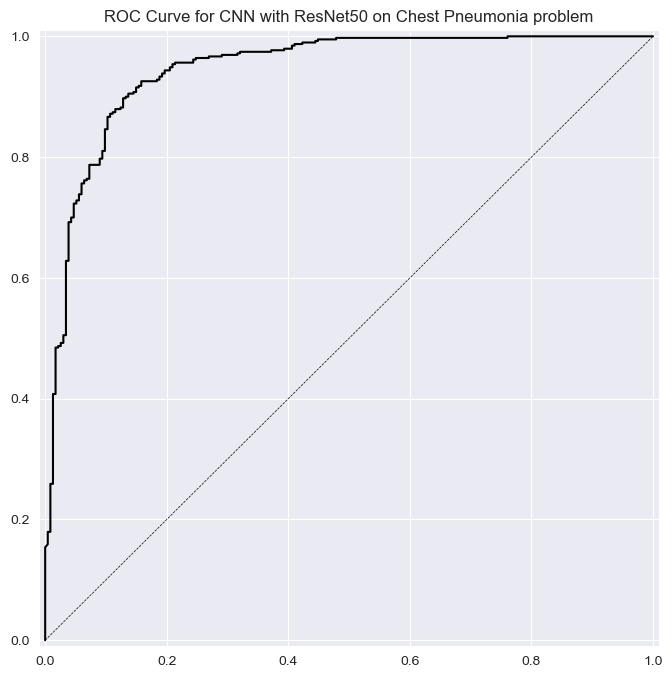

In [54]:
print_roc(y_test, predict_X_5, y_pred_prob_5, "CNN with ResNet50")

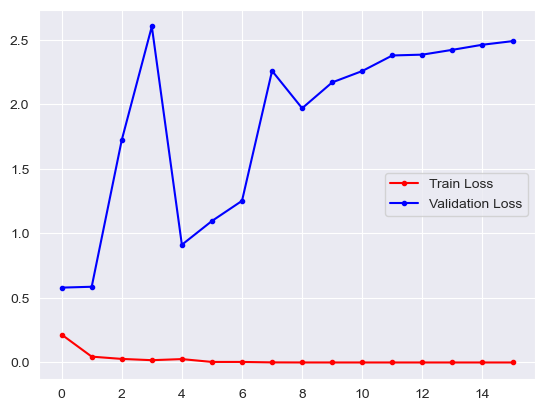

In [55]:
# Plot the training loss and the validation loss over the different epochs.
plot_train_model(run_hist_5)